In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
#Building vocabulary of words and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
#Building the dataset
block_size = 3 #Context length to specify how many characters we consider to predict the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
    
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] #sliding window
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #90%
Xte, Yte = build_dataset(words[n2:]) #10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
#Building a deeper network and pytorchifying code

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    #forward pass
    def __call__(self, x): #x is input tensor
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        #buffers(trained with a running momentum update)
        self.running_mean = torch.zeroes(dim)
        self.running_var = torch.zeroes(dim)

    def __call__(self, x): #x is input tensor which is a batch.
        #forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out


    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []



In [8]:

g = torch.Generator().manual_seed(2147483647)

n_emb = 10 #Embedding dimension
n_hidden = 100 #No. of neurons in the hidden layer

C = torch.randn((vocab_size, n_emb), generator=g)

layers = [
    Linear(n_emb*block_size, n_hidden), Tanh(),
    Linear(        n_hidden, n_hidden), Tanh(),
    Linear(        n_hidden, n_hidden), Tanh(),
    Linear(        n_hidden, n_hidden), Tanh(),
    Linear(        n_hidden, n_hidden), Tanh(),
    Linear(        n_hidden, vocab_size),
]

with torch.no_grad():
    #make last layer less confident
    layers[-1].weight *= 0.1
    #add gain to the other linear layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [18]:
#optimization

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) #concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update weights
    lr = 0.1 if i<100000 else 0.01 #step lr decay
    for p in parameters:
        p.data += -lr * p.grad

    #tracking stats
    if i%10000==0:
        print(f'{i:7d}/{max_steps:4d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/200000 : 3.2406
  10000/200000 : 2.1308
  20000/200000 : 2.1678
  30000/200000 : 1.9966
  40000/200000 : 2.1159
  50000/200000 : 2.0640
  60000/200000 : 2.2851
  70000/200000 : 2.3379
  80000/200000 : 1.8009
  90000/200000 : 1.8712
 100000/200000 : 2.3531
 110000/200000 : 1.6022
 120000/200000 : 1.8502
 130000/200000 : 1.6604
 140000/200000 : 1.5093
 150000/200000 : 2.3040
 160000/200000 : 2.0107
 170000/200000 : 2.0182
 180000/200000 : 2.1725
 190000/200000 : 1.9249


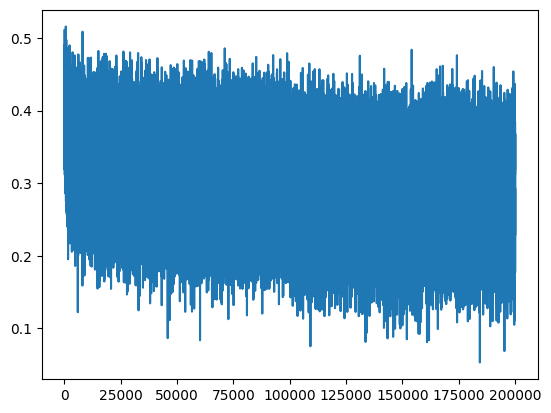

In [19]:
plt.plot(lossi)

In [20]:
#Sampling from model


for i in range(10):
    
    ix = 0
    
    context = [0] * block_size 
    out = []
    
    while True:
        #do a forward pass and get the final distribution then sample from it to get next character and keep sampling until I run into a '.'
        
        emb = C[context]
        emb = emb.view(1, n_emb*block_size)
        for layer in layers:
            emb = layer(emb)
        
        #pass it through a softmax
        counts = emb.exp()
        probs = counts / counts.sum(1, keepdim=True)
        
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        
        out.append(itos[ix])
        context = context[1:] + [ix]
    
        if ix==0:
            break
    
    
    print(''.join(j for j in out))
        

hayleah.
iya.
mari.
clayden.
adelys.
erik.
azi.
luelon.
arcelin.
brystani.


In [ ]:
#Results after just one single training loop
# rauwqrmxztzfvw.
# tystcmkbsdvcnayjf.
# wzbnzdxccozhsitayxu.
# wbesppzulxntfzohnlaabycxoocvmcbsodxmnmzji.
# tetibfofiqzogakdtqyvenj.
# krgdfibakq.
# pjexqhbzdzlkvwrbindwapolpgrbdgogr.
# kmqhaldhywherzxlbfnwimuq.
# hdfqsecluyzkgllpprshykgwdhuqxol.
# qwamtvxskkebcqtcldfnmt.

#The results after training are quite nice compared to the prev model with only a single layer but still more to improve.